In [15]:
import numpy as np
import pandas as pd
import joblib
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [21]:
# CONFIGURATION
# Update this path to match your local machine exactly
BASE_DIR = r"C:\Users\ayber\OneDrive\Masaüstü\ML"

DATA_PATH = os.path.join(BASE_DIR, "Data/processed/irb2400_ready_v2.csv")
RAW_PATH = os.path.join(BASE_DIR, "Data/external/datasetIRB2400.csv")

# Models
MODEL_PATH = os.path.join(BASE_DIR, "Models/mlp_baseline_v2.pkl")
SCALER_X_PATH = os.path.join(BASE_DIR, "Models/scaler_x_v2.pkl")
SCALER_Y_PATH = os.path.join(BASE_DIR, "Models/scaler_y_v2.pkl")

# Output for Figures
FIGURE_DIR = os.path.join(BASE_DIR, "Reports/Figures")
os.makedirs(FIGURE_DIR, exist_ok=True)

In [22]:
# 1. KINEMATICS ENGINE FOR IRB2400 ROBOT
class IRB2400_Kinematics:
    def __init__(self):
        self.d1, self.a1 = 0.615, 0.100
        self.a2, self.a3 = 0.705, 0.0315
        self.d4, self.d6 = 0.755, 0.1547
        self.offsets = [0, 0, 180, 0, 0, 0] 
        self.limits = [(-180, 180), (-100, 110), (-60, 65), (-200, 200), (-120, 120), (-400, 400)]

    def _dh_matrix(self, theta, d, a, alpha):
        t = np.radians(theta)
        alp = np.radians(alpha)
        c, s = np.cos(t), np.sin(t)
        ca, sa = np.cos(alp), np.sin(alp)
        return np.array([
            [c, -s*ca, s*sa, a*c],
            [s, c*ca, -c*sa, a*s],
            [0, sa,    ca,   d],
            [0, 0,     0,    1]
        ])

    def forward_kinematics(self, joints_deg):
        q = np.array(joints_deg) + np.array(self.offsets)
        T01 = self._dh_matrix(q[0], self.d1, self.a1, -90)
        T12 = self._dh_matrix(q[1], 0,       self.a2, 0)
        T23 = self._dh_matrix(q[2], 0,       self.a3, -90)
        T34 = self._dh_matrix(q[3], self.d4, 0,       90)
        T45 = self._dh_matrix(q[4], 0,       0,       -90)
        T56 = self._dh_matrix(q[5], self.d6, 0,       0)
        return (T01 @ T12 @ T23 @ T34 @ T45 @ T56)[:3, 3]

    def get_jacobian(self, joints_deg):
        epsilon = 1e-4
        J = np.zeros((3, 6))
        current_pos = self.forward_kinematics(joints_deg)
        for i in range(6):
            q_p = np.array(joints_deg, dtype=float)
            q_p[i] += epsilon
            J[:, i] = (self.forward_kinematics(q_p) - current_pos) / epsilon
        return J

    def check_limits(self, joints_deg):
        for i, (min_l, max_l) in enumerate(self.limits):
            if not (min_l <= joints_deg[i] <= max_l): return False
        return True


In [23]:
# 2. HYBRID SOLVER (USING ML + NUMERICAL IK)
class HybridIKSolver:
    def __init__(self):
        print("Loading v2 AI Models...")
        self.model = joblib.load(MODEL_PATH)
        self.scaler_x = joblib.load(SCALER_X_PATH)
        self.scaler_y = joblib.load(SCALER_Y_PATH)
        self.robot = IRB2400_Kinematics()

    def solve(self, target_pose, current_joints, tolerance=0.001, max_iter=50): 
        stats = {'method': 'ML', 'iterations': 0, 'final_error': 0.0, 'time': 0.0, 'valid_limits': True}
        start_time = time.time()

        # Feature Engineering
        x, y, z, yaw, pitch, roll = target_pose
        features = np.array([
            x, y, z,
            np.sin(yaw), np.cos(yaw),
            np.sin(pitch), np.cos(pitch),
            np.sin(roll), np.cos(roll),
            *current_joints
        ])
        
        input_scaled = self.scaler_x.transform([features])
        delta_deg = self.scaler_y.inverse_transform(self.model.predict(input_scaled))[0]
        q_guess = current_joints + delta_deg
        
        current_pos_xyz = self.robot.forward_kinematics(q_guess)
        target_xyz = target_pose[:3]
        error = np.linalg.norm(current_pos_xyz - target_xyz)
        stats['ml_error'] = error
        stats['final_error'] = error

        if error > tolerance:
            stats['method'] = 'Hybrid'
            damping = 0.01 
            for i in range(max_iter):
                J = self.robot.get_jacobian(q_guess)
                delta_x = target_xyz - current_pos_xyz
                
                lambda_sq = damping**2 * np.eye(3)
                try:
                    J_inv = J.T @ np.linalg.inv(J @ J.T + lambda_sq)
                    delta_q = J_inv @ delta_x
                except:
                    break 

                q_new = q_guess + delta_q
                pos_new = self.robot.forward_kinematics(q_new)
                err_new = np.linalg.norm(pos_new - target_xyz)
                
                if err_new < error:
                    q_guess = q_new
                    current_pos_xyz = pos_new
                    error = err_new
                    damping *= 0.5 
                else:
                    damping *= 5.0 
                damping = np.clip(damping, 1e-4, 10.0)

                if error < tolerance:
                    stats['iterations'] = i + 1
                    break
            stats['final_error'] = error
            
        stats['time'] = (time.time() - start_time) * 1000 
        stats['valid_limits'] = self.robot.check_limits(q_guess)
        return q_guess, stats


In [27]:
# 3. PDF-STYLE VISUALIZATIONS
def plot_joint_predictions(y_true, y_pred):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Joint Angle Tracking: True vs Predicted', fontsize=16)
    
    axes = axes.flatten()
    for i in range(6):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.5, s=2, color='orange', label='Predicted')
        ax.plot([y_true[:, i].min(), y_true[:, i].max()], [y_true[:, i].min(), y_true[:, i].max()], 'b--', lw=1, label='Ideal')
        ax.set_title(f'Joint {i+1} (q{i+1})')
        ax.set_xlabel('True Angle (deg)')
        ax.set_ylabel('Predicted Angle (deg)')
        if i == 0: ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(os.path.join(FIGURE_DIR, "joint_tracking_scatter.png"), dpi=300)
    print("Saved Joint Tracking Scatter Plot.")

def plot_joint_residuals(y_true, y_pred):
    """Plots 6 histograms of errors similar to PDF Fig. 13"""
    errors = y_pred - y_true
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Residual Error Distribution per Joint', fontsize=16)
    
    axes = axes.flatten()
    for i in range(6):
        ax = axes[i]
        # Filter outliers for cleaner plot range
        data = errors[:, i]
        q_range = np.percentile(data, [1, 99])
        
        sns.histplot(data, bins=50, kde=True, ax=ax, color='green')
        ax.set_xlim(q_range[0], q_range[1]) # Zoom in on the peak
        ax.set_title(f'Joint {i+1} Residuals')
        ax.set_xlabel('Error (deg)')
        ax.grid(True, alpha=0.3)
        
        # Add stats
        mae = np.mean(np.abs(data))
        ax.text(0.05, 0.9, f"MAE: {mae:.4f}°", transform=ax.transAxes, fontweight='bold')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(os.path.join(FIGURE_DIR, "joint_residuals_hist.png"), dpi=300)
    print("Saved Joint Residuals Plot.")

def plot_3d_trajectory_demo(solver):
    print("Generating 3D Trajectory Demo...")
    
    # 1. Generate Spiral Trajectory
    t = np.linspace(0, 4*np.pi, 100)
    radius = 0.3
    center = [0.8, 0.0, 1.2] # Safe workspace center
    
    x_traj = center[0] + radius * np.cos(t)
    y_traj = center[1] + radius * np.sin(t)
    z_traj = center[2] + 0.05 * t # Moving up
    
    # Orientation (Fixed facing down)
    yaw, pitch, roll = 0, np.pi/2, 0
    
    actual_path = []
    current_q = np.zeros(6) # Start from home/zero
    
    # 2. Solve Path
    for i in range(len(t)):
        target = np.array([x_traj[i], y_traj[i], z_traj[i], yaw, pitch, roll])
        # Use previous solution as next current_q (path tracking mode)
        q_sol, _ = solver.solve(target, current_q, tolerance=0.001, max_iter=20)
        
        # Calculate actual reached position
        pos_reached = solver.robot.forward_kinematics(q_sol)
        actual_path.append(pos_reached)
        current_q = q_sol # Update state
        
    actual_path = np.array(actual_path)
    
    # 3. Plot 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot Target
    ax.plot(x_traj, y_traj, z_traj, 'b--', label='Target Trajectory', lw=2)
    # Plot Actual
    ax.plot(actual_path[:,0], actual_path[:,1], actual_path[:,2], 'r-', label='Hybrid Solver Path', lw=1.5, alpha=0.7)
    
    # Labels
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('3D Path Tracking Performance (Spiral)')
    ax.legend()
    
    plt.savefig(os.path.join(FIGURE_DIR, "3d_trajectory_tracking.png"), dpi=300)
    print("Saved 3D Trajectory Plot.")

Loading Raw Data from C:\Users\ayber\OneDrive\Masaüstü\ML\Data/external/datasetIRB2400.csv...
Loading v2 AI Models...

Running Stress Test & Data Collection...

Generating Report Figures...


C:\Users\ayber\AppData\Local\Temp\ipykernel_20916\4261977681.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([res_df['ml_error_mm'], res_df['final_error_mm']], labels=['Pure ML', 'Hybrid'], showfliers=False)


Saved Joint Tracking Scatter Plot.
Saved Joint Residuals Plot.
Generating 3D Trajectory Demo...
Saved 3D Trajectory Plot.
All plots saved to C:\Users\ayber\OneDrive\Masaüstü\ML\Reports/Figures


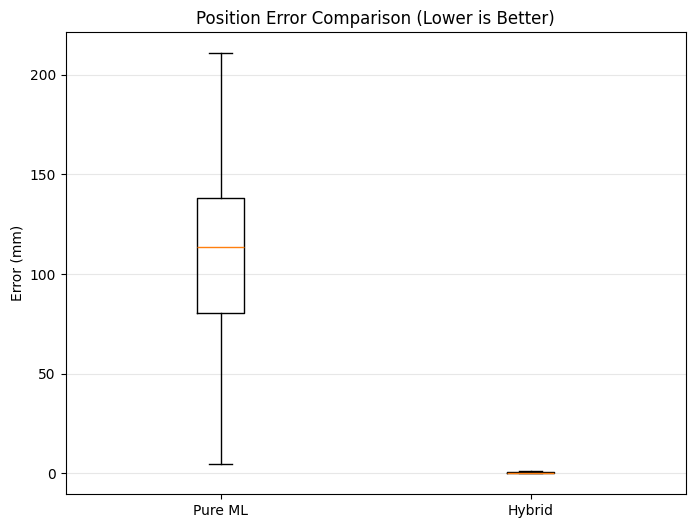

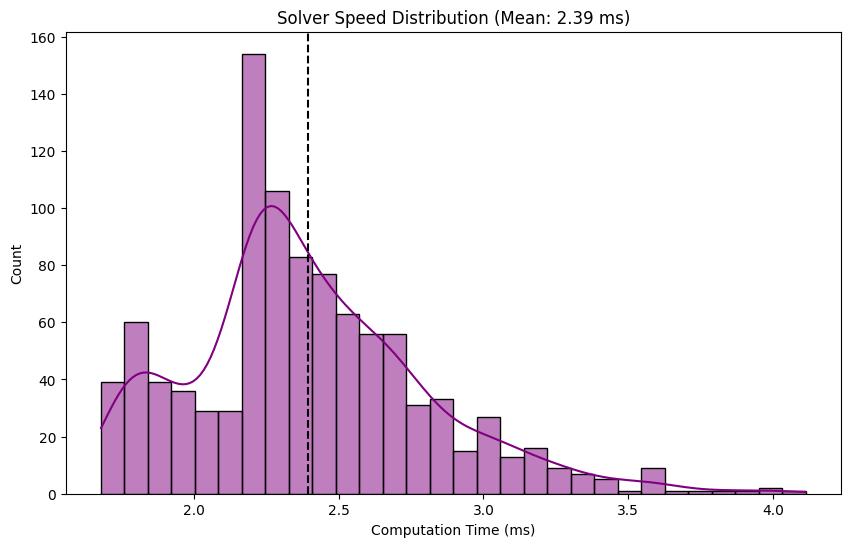

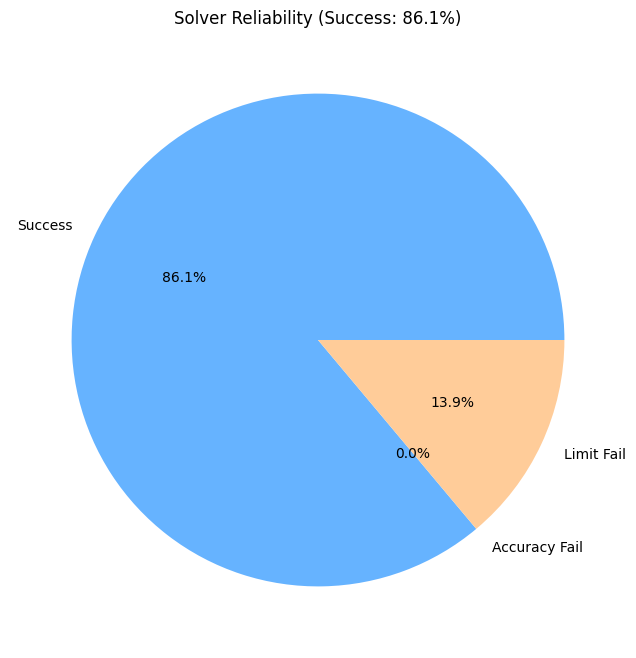

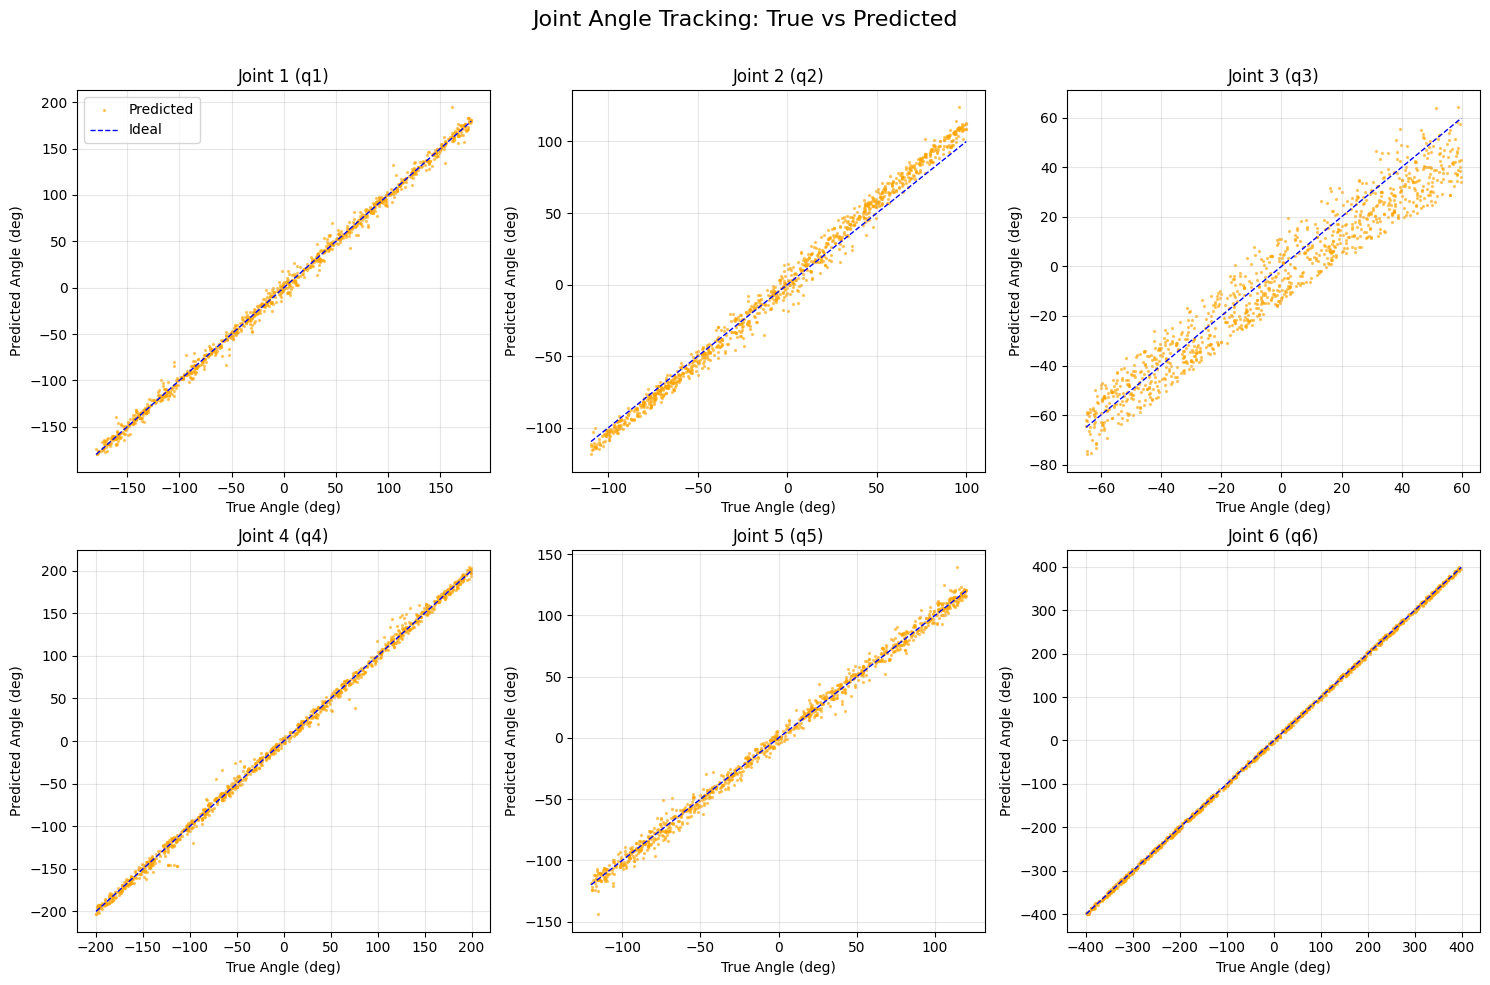

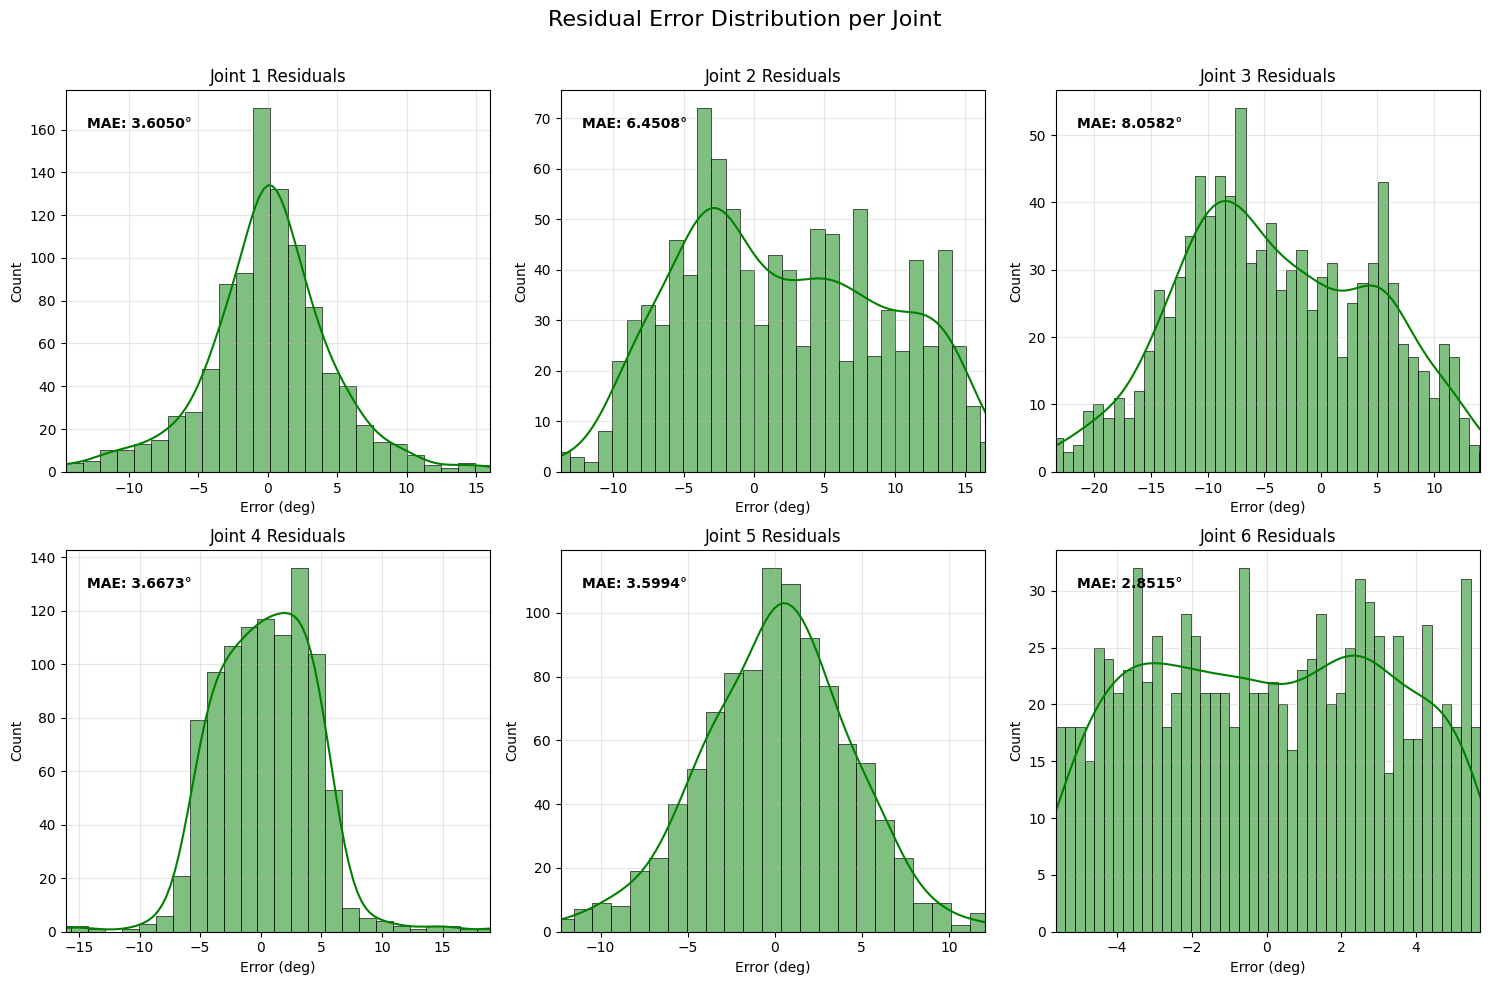

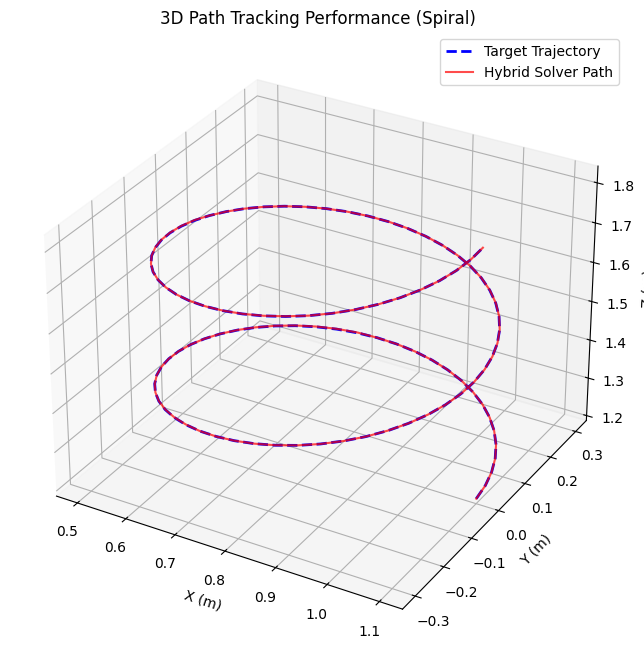

In [28]:
# 4. MAIN RUNNER
if __name__ == "__main__":
    print(f"Loading Raw Data from {RAW_PATH}...")
    # Load data for stress test
    df = pd.read_csv(RAW_PATH).sample(1000, random_state=2)
    solver = HybridIKSolver()
    
    results = []
    true_joints = []
    pred_joints = []
    
    print("\nRunning Stress Test & Data Collection...")
    
    for idx, row in df.iterrows():
        target = np.array([
            row['x']/1000.0, row['y']/1000.0, row['z']/1000.0, 
            row['yaw'], row['pitch'], row['roll']
        ])
        # Get True Joints (Ground Truth from Dataset)
        q_true = np.degrees(row[['q1_out', 'q2_out', 'q3_out', 'q4_out', 'q5_out', 'q6_out']].values)
        
        # Get Current Joints (Input)
        current_q = np.degrees(row[['q1_in', 'q2_in', 'q3_in', 'q4_in', 'q5_in', 'q6_in']].values)
        
        # Solve
        q_sol, info = solver.solve(target, current_q, tolerance=0.001, max_iter=50)
        
        # Store Data for Plots
        true_joints.append(q_true)
        pred_joints.append(q_sol)
        
        info['ml_error_mm'] = info['ml_error'] * 1000
        info['final_error_mm'] = info['final_error'] * 1000
        results.append(info)

    res_df = pd.DataFrame(results)
    true_joints = np.array(true_joints)
    pred_joints = np.array(pred_joints)
    
    # GENERATE STANDARD PLOTS
    print("\nGenerating Report Figures...")
    
    # 1. Accuracy Boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot([res_df['ml_error_mm'], res_df['final_error_mm']], labels=['Pure ML', 'Hybrid'], showfliers=False)
    plt.title("Position Error Comparison (Lower is Better)")
    plt.ylabel("Error (mm)")
    plt.grid(True, axis='y', alpha=0.3)
    plt.savefig(os.path.join(FIGURE_DIR, "accuracy_boxplot.png"), dpi=300)
    
    # 2. Speed Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(res_df['time'], bins=30, kde=True, color='purple')
    plt.title(f"Solver Speed Distribution (Mean: {res_df['time'].mean():.2f} ms)")
    plt.xlabel("Computation Time (ms)")
    plt.axvline(res_df['time'].mean(), color='k', linestyle='--', label='Mean')
    plt.savefig(os.path.join(FIGURE_DIR, "speed_histogram.png"), dpi=300)
    
    # 3. Failure Pie Chart
    success = (res_df['final_error_mm'] < 1.0) & (res_df['valid_limits'] == True)
    acc_fail = (res_df['final_error_mm'] >= 1.0)
    lim_fail = (res_df['final_error_mm'] < 1.0) & (res_df['valid_limits'] == False)
    
    plt.figure(figsize=(8, 8))
    plt.pie([success.sum(), acc_fail.sum(), lim_fail.sum()], 
            labels=['Success', 'Accuracy Fail', 'Limit Fail'], 
            autopct='%1.1f%%', colors=['#66b3ff', '#ff9999', '#ffcc99'])
    plt.title(f"Solver Reliability (Success: {success.sum()/len(res_df)*100:.1f}%)")
    plt.savefig(os.path.join(FIGURE_DIR, "failure_analysis_pie.png"), dpi=300)
    
    # GENERATE NEW PDF-STYLE PLOTS
    plot_joint_predictions(true_joints, pred_joints)
    plot_joint_residuals(true_joints, pred_joints)
    
    # Run 3D Trajectory Demo
    plot_3d_trajectory_demo(solver)
    
    print(f"All plots saved to {FIGURE_DIR}")